# Preview - Article Coming Soon

# Step #1 Initialize Spark Session

In [2]:
# A tutorial for this file is available at www.relataly.com

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean, explode
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

# Step #2 Load the Weather Data

In [3]:
# Read File A
spark_weather_df_a = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_a')

spark_weather_df_a.printSchema()
print(spark_weather_df_a.count())
spark_weather_df_a.limit(3).toPandas()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)

15384


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9
0,0,2020-01-01,-1.8,0.0,0.0,63.0,4.2,14.8,1034.6,None
1,1,2020-01-02,-1.3,0.0,0.0,196.0,2.8,11.1,1032.2,None
2,2,2020-01-03,2.8,0.9,0.0,226.0,7.6,27.8,1028.6,None


In [4]:
# Read File B
spark_weather_df_b = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_b')

spark_weather_df_b.printSchema()
print(spark_weather_df_b.count())
spark_weather_df_b.limit(3).toPandas()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)

15383


,_c0,_c1,_c2,_c3
0,0,2005-01-01,6.8,1.5
1,1,2005-01-02,7.3,1.9
2,2,2005-01-03,4.3,0.7


# Step #3 Adjust Columns and  Join the Data

In [5]:
# Drop unused Columns
spark_weather_df_a = spark_weather_df_a.drop("_c0")
spark_weather_df_b = spark_weather_df_b.drop("_c0")

In [6]:
# rename columns

# method A: rename individual columns
spark_weather_df_b_renamed = spark_weather_df_b.withColumnRenamed("_c1", "date") \
    .withColumnRenamed("_c2", "max_temp") \
    .withColumnRenamed("_c3", "min_temp") 
        
# method B: rename multiple columns at once   
def rename_multiple_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[F.col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("columns need to be in dict format {'existing_name_a':'new_name_a', 'existing_name_b':'new_name_b'}")

dict_columns = {"_c1": "date2", 
                "_c2": "avg_temp", 
                "_c3": "precip",
                "_c4": "snow",
                "_c5": "wind_dir",
                "_c6": "wind_speed",
                "_c7": "wind_power",
                "_c8": "air_pressure",
                "_c9": "sunny_hours",}
spark_weather_df_a_renamed = rename_multiple_columns(spark_weather_df_a , dict_columns)

In [7]:
# Join the dataframes
spark_weather_df = spark_weather_df_a_renamed.join(spark_weather_df_b_renamed, spark_weather_df_a_renamed.date2 == spark_weather_df_b_renamed.date, "inner")

# Step #4 Gain a Quick Overview of the Data

In [8]:
def quick_overview(df):
   # display the spark dataframe
   print("FIRST RECORDS")
   print(df.limit(2).sort(col("date"), ascending=True).toPandas())

   # count null values
   print("COUNT NULL VALUES")
   print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in df.dtypes if y in ["double", "float"]]
      ).toPandas())

   # print("DESCRIBE STATISTICS")
   # print(df.describe().toPandas())
   # # Alternatively to get the max value, we could use max_value = df.agg({"precipitation": "max"}).collect()[0][0]

   # print schema
   print("PRINT SCHEMA")
   print(df.printSchema())

quick_overview(spark_weather_df)

FIRST RECORDS
        date2  avg_temp  precip  snow  wind_dir  wind_speed  wind_power  \
0  2020-01-01      -1.8     0.0   0.0      63.0         4.2        14.8   
1  2020-01-01      -1.8     0.0   0.0      63.0         4.2        14.8   

   air_pressure sunny_hours        date  max_temp  min_temp  
0        1034.6        None  2020-01-01      -0.9      -2.9  
1        1034.6        None  2020-01-01      -0.9      -2.9  
COUNT NULL VALUES
   avg_temp  precip  snow  wind_dir  wind_speed  wind_power  air_pressure  \
0        21       0   143     14577       14565       14565         14565   

   max_temp  min_temp  
0         9        15  
PRINT SCHEMA
root
 |-- date2: string (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- wind_dir: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_power: double (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- sunny_hours

# Step #5 Clean the Data

In [9]:
# show null values
spark_weather_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_weather_df.columns]
   ).toPandas()

,date2,avg_temp,precip,snow,wind_dir,wind_speed,wind_power,air_pressure,sunny_hours,date,max_temp,min_temp
0,0,21,0,143,14577,14565,14565,14565,15466,0,9,15


In [10]:
# filter Null values
spark_weather_df = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())

In [11]:
#replace na values
avg = spark_weather_df.select(mean(col('min_temp')).alias('mean_min'), mean(col('max_temp')).alias('mean_max'), mean(col('wind_speed')).alias('mean_wind')).collect()
mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']
mean_wind = avg[0]['mean_wind']

spark_weather_df = spark_weather_df \
    .na.fill(value=mean_min, subset=["min_temp"]) \
    .na.fill(value=mean_max, subset=["max_temp"]) \
    .na.fill(value=mean_wind, subset=["wind_speed"]) \
    .na.fill(value=0, subset=["snow"]) 


In [12]:
# check for dublicates
spark_weather_df.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .limit(5).toPandas()

,date,count
0,1986-01-01,4
1,2011-01-01,4
2,2005-01-01,4
3,1985-01-01,4
4,2006-01-01,4


In [13]:
# remove dublicates and drop column date2, convert date to datatype "date", Sort the Data by Date
spark_weather_df = spark_weather_df.dropDuplicates()


In [14]:
# drop date2 column, convert date column from string to date type, order by date
df = spark_weather_df.drop(col("date2"))\
    .withColumn("date", to_date(col("date"),"yyyy-MM-dd")) \
    .orderBy(col("date"))

In [15]:
# select columns
spark_cleaned_df = df.select(df.date, df.avg_temp, df.min_temp, df.max_temp, df.wind_speed, df.snow, df.precip)

In [16]:
quick_overview(spark_cleaned_df)

FIRST RECORDS
         date  avg_temp  min_temp  max_temp  wind_speed  snow  precip
0  1979-01-01      -5.3     -12.2      -2.5    7.326082   0.0     1.0
1  1979-01-02     -10.0     -12.2      -4.2    7.326082  10.0     1.7
COUNT NULL VALUES
   avg_temp  min_temp  max_temp  wind_speed  snow  precip
0         0         0         0           0     0       0
PRINT SCHEMA
root
 |-- date: date (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- min_temp: double (nullable = false)
 |-- max_temp: double (nullable = false)
 |-- wind_speed: double (nullable = false)
 |-- snow: double (nullable = false)
 |-- precip: double (nullable = true)

None


# Step #6 Transform the Data using User Defined Functions (UDF)

In [17]:
# More Infos on User Defined Functions: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
# create bucket column for temperature
def binner(min_temp, max_temp):
        if (min_temp is None) or (max_temp is None):
            return "unknown"
        else:
            if min_temp < -10:
                return "freezing cold"
            elif min_temp < -5:
                return "very cold"
            elif min_temp < 0:
                return "cold"
            elif max_temp < 10:
                return "normal"
            elif max_temp < 20:
                return "warm"
            elif max_temp < 30:
                return "hot"
            elif max_temp >= 30:
                return "very hot"
        return "normal"


udf_binner_temp = udf(binner, StringType() )

spark_cleaned_df = spark_cleaned_df.withColumn("temp_buckets", udf_binner_temp(col("min_temp"), col("max_temp")))
spark_cleaned_df.limit(10).toPandas()

,date,avg_temp,min_temp,max_temp,wind_speed,snow,precip,temp_buckets
0,1979-01-01,-5.3,-12.2,-2.5,7.326082,0.0,1.0,freezing cold
1,1979-01-02,-10.0,-12.2,-4.2,7.326082,10.0,1.7,freezing cold
2,1979-01-03,-5.8,-7.9,-3.9,7.326082,110.0,0.0,very cold
3,1979-01-04,-8.4,-10.5,-4.4,7.326082,100.0,0.0,freezing cold
4,1979-01-05,-10.0,-11.2,-7.5,7.326082,70.0,0.0,freezing cold
5,1979-01-06,-6.4,-10.1,-2.8,7.326082,50.0,0.0,freezing cold
6,1979-01-07,-3.8,-5.1,-2.9,7.326082,40.0,0.0,very cold
7,1979-01-08,-2.4,-4.5,1.4,7.326082,40.0,5.1,cold
8,1979-01-09,1.4,-0.4,3.8,7.326082,20.0,3.2,cold
9,1979-01-10,0.4,-1.4,2.8,7.326082,10.0,5.4,cold


In [18]:
# create a bucket column for percipitation
udf_binner_precip = udf(lambda x: "very rainy" if x > 50 else ("rainy" if x > 0 else "dry"), StringType())
spark_cleaned_df = spark_cleaned_df.withColumn("precip_buckets", udf_binner_precip("precip"))
spark_cleaned_df.limit(5).toPandas()

,date,avg_temp,min_temp,max_temp,wind_speed,snow,precip,temp_buckets,precip_buckets
0,1979-01-01,-5.3,-12.2,-2.5,7.326082,0.0,1.0,freezing cold,rainy
1,1979-01-02,-10.0,-12.2,-4.2,7.326082,10.0,1.7,freezing cold,rainy
2,1979-01-03,-5.8,-7.9,-3.9,7.326082,110.0,0.0,very cold,dry
3,1979-01-04,-8.4,-10.5,-4.4,7.326082,100.0,0.0,freezing cold,dry
4,1979-01-05,-10.0,-11.2,-7.5,7.326082,70.0,0.0,freezing cold,dry


In [19]:
#create additional columns for month and year
spark_cleaned_df = spark_cleaned_df.withColumn("month", month(spark_cleaned_df.date)) \
    .withColumn("year", year(spark_cleaned_df.date))

# Step #7 Data Analysis

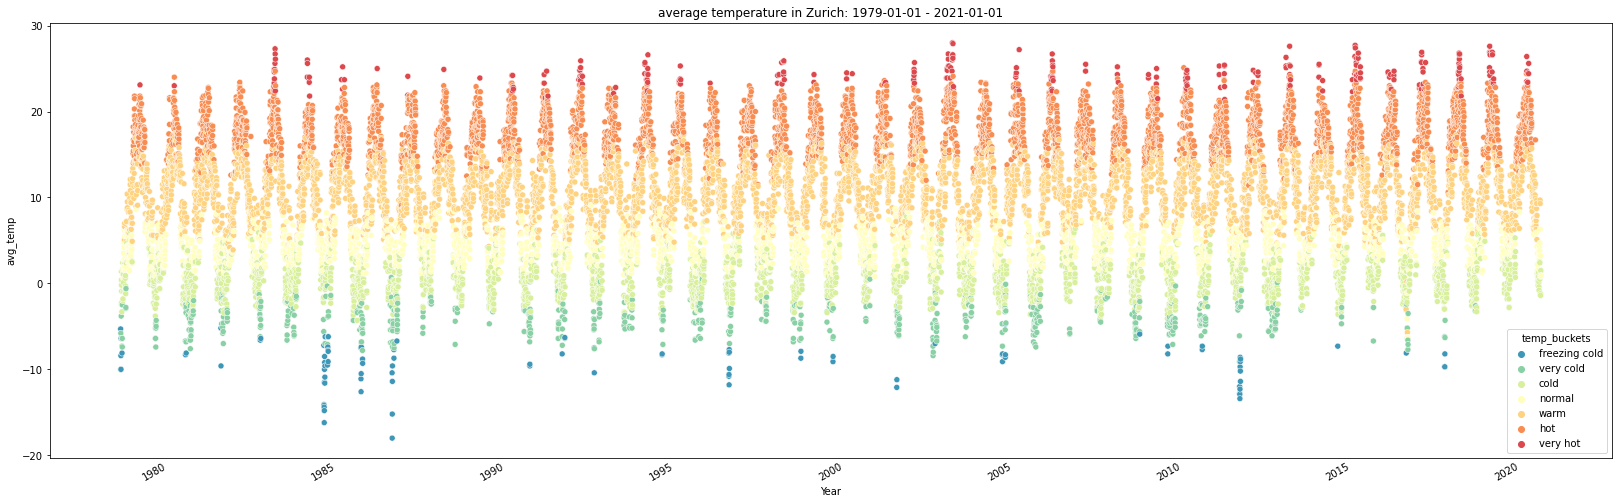

In [41]:
# set the dimensions for the scatterplot
fig, ax = plt.subplots(figsize=(28,8))
sns.scatterplot(hue="temp_buckets", y="avg_temp", x="date", data=spark_cleaned_df.toPandas(), palette="Spectral_r")

# plot formatting 
ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)

# title formatting
mindate = str(spark_cleaned_df.agg({'date': 'min'}).collect()[0]['min(date)'])
maxdate = str(spark_cleaned_df.agg({'date': 'max'}).collect()[0]['max(date)'])
ax.set_title("average temperature in Zurich: " + mindate + " - " + maxdate)
plt.xlabel("Year")
plt.show()

<AxesSubplot:xlabel='year', ylabel='month'>

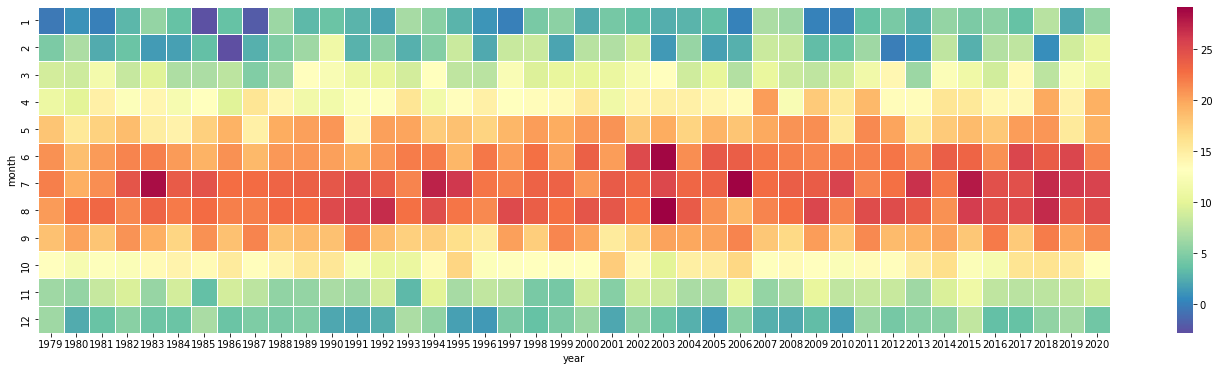

In [140]:
spark_cleaned_df_agg = spark_cleaned_df.select(col("year"),col("month"),col("max_temp")) \
    .filter(spark_cleaned_df.year < 2021)\
    .groupby(col("year"),col("month"))\
    .agg(mean("max_temp").alias("mean_max_temp")) \
    .orderBy(col("year")).toPandas()

plt.figure(figsize=(24,6))
avg_temp_df = spark_cleaned_df_agg.pivot("month", "year", "mean_max_temp")
sns.heatmap(avg_temp_df, cmap="Spectral_r", linewidths=.5)

# Step #7.2 SQL PySpark

   year  month  mean(avg_temp)  mean(max_temp)  mean(min_temp)
0  1979      5       19.180000       26.940000       12.900000
1  1979      6       19.200000       25.842857       14.385714
2  1979      7       20.828571       27.071429       15.357143
3  1979      8       20.200000       27.000000       14.216667
4  1979      9       19.000000       25.400000       13.700000


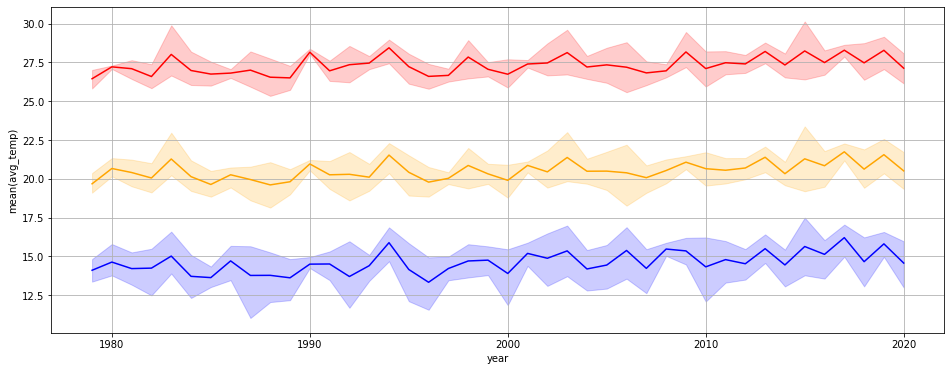

In [141]:
# Using PySpark standard functions
# events_over_years_df = spark_cleaned_df\
#     .filter(spark_cleaned_df.year < 2021)\
#     .groupby(col("year"))\
#     .agg(mean("avg_temp").alias("mean_avg_temp"), 
#          mean("min_temp").alias("mean_min_temp"), 
#          mean("max_temp").alias("mean_max_temp"))\
#     .orderBy(col("year")).toPandas()

# plt.figure(figsize=(15,6))


# Data Analysis using PySpark.SQL

# register the dataset as a temp view, so we can use sq
spark_cleaned_df.createOrReplaceTempView("waeather_data_temp_view")

# see how event numbers have evolved over years
events_over_years_df = spark.sql( \
        'SELECT year, month, mean(avg_temp), mean(max_temp), mean(min_temp) \
        FROM waeather_data_temp_view \
        WHERE max_temp > 25 \
        GROUP BY month, year \
        ORDER BY year, month')
print(events_over_years_df.limit(5).toPandas())

plt.figure(figsize=(16,6))
fig = sns.lineplot(y="mean(avg_temp)", x="year", data=events_over_years_df.toPandas(), color= "orange")
fig = sns.lineplot(y="mean(max_temp)", x="year", data=events_over_years_df.toPandas(), color= "red")
fig = sns.lineplot(y="mean(min_temp)", x="year", data=events_over_years_df.toPandas(), color= "blue")
plt.grid()
plt.show()


# Step 7.3 Scatter Plots

Text(0.5, 1.0, 'min - max temperature seperated by month')

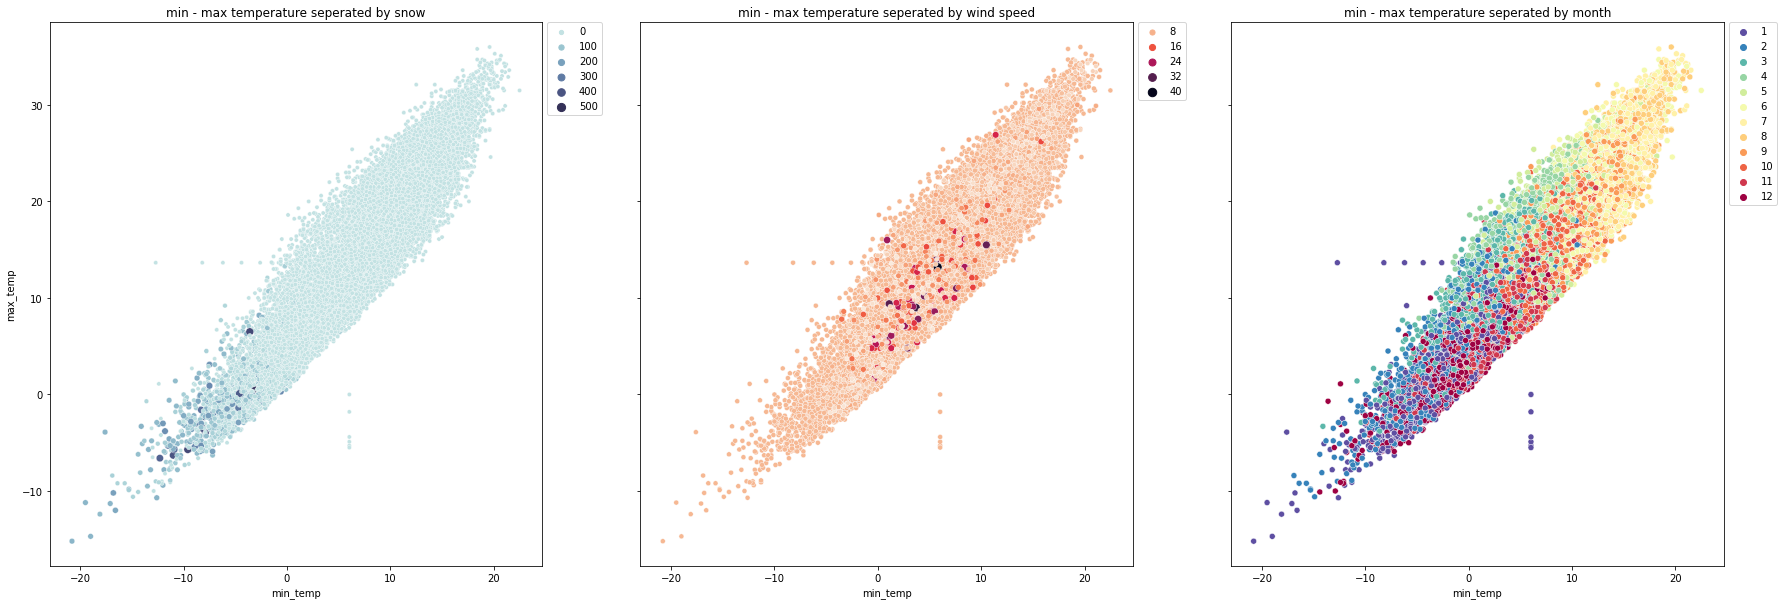

In [144]:
fig, axes= plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(ax = axes[0], hue="snow", size="snow", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette=palette)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[0].set_title("min - max temperature seperated by snow")

sns.scatterplot(ax = axes[1], hue="wind_speed", size="wind_speed", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette='rocket_r')
axes[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[1].set_title("min - max temperature seperated by wind speed")

sns.scatterplot(ax = axes[2], hue="month", y="max_temp", x="min_temp", data=spark_cleaned_df.toPandas(), alpha=1.0, palette='Spectral_r', hue_norm=(1,12), legend="full")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[2].set_title("min - max temperature seperated by month")
